# Cálculo del quemado de un EE.CC. a partir de las cuentas neutrónicas del SICOM-NG-FA y otras variables de interés.

In [1]:
import pandas as pd

df = pd.read_csv("DataSet.csv", sep=';', index_col="ind")
# df.head()

### Codificación de la categoría TipoEC

In [2]:
# df.TipoEC.value_counts()

dummies = pd.get_dummies(df['TipoEC'])
df = pd.concat([df, dummies], axis = 1)
df.drop('TipoEC', axis=1, inplace=True)
# df.head()

### Reordeno los datos y elimino varias columnas [Cnn y T(ms), porque son combinación lineal de Cnn/s; AEF, porque es la ausencia de MAEF, OFA y STD simultáneamente]

In [3]:
df = df [['EECC', 'Muestra', 'MAEF', 'OFA', 'STD', 'Cnn/s', 'Ciclos', 'Enf(mes)', 'Enr(%)', 'Mwd/TnU']]
# df.head()

### Data frame con datos tificados + data frame logarítmico 

In [4]:
import numpy as np
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer


# Creo una función para tipificar las columnas del df
def TipificarColumnas(dataframe, column):
    dataframe[column] = dataframe[column].astype(float)
    dataframe[column] = stats.zscore(dataframe[column])
    return dataframe

# Copio el df para no modificar el original y tipifico las cinco últimas columnas
data = df.copy()
for column in data.columns[-5:]:
    data = TipificarColumnas(data, column)


# Creo otro data frame con los logaritmos de las variables explicativas
dataL = df.copy()
for column in dataL.columns[-5:-1]:
    dataL[column] = np.log(dataL[column])

# data.head()
# dataL.head()

### Cálculo de estadísticos

In [5]:
from scipy.stats import iqr

# Por algún motivo asigna por defecto el tipo object a los estadísticos, así que
# especifico que los quiero de tipo float para que les aplique set_printoptions.
medias = np.mean(data.values[:,5:], axis=0).astype(float)
varianzas = np.var(data.values[:,5:], axis=0).astype(float)
medianas = np.median(data.values[:,5:], axis=0).astype(float)
intercuartil = iqr(data.values[:,5:], axis=0).astype(float)
# print(medias.dtype, varianzas.dtype, medianas.dtype, intercuartil.dtype)
mediasL = np.mean(dataL.values[:,5:], axis=0).astype(float)
varianzasL = np.var(dataL.values[:,5:], axis=0).astype(float)
medianasL = np.median(dataL.values[:,5:], axis=0).astype(float)
intercuartilL = iqr(dataL.values[:,5:], axis=0).astype(float)


np.set_printoptions(precision = 3)


# Compruebo que las variables están tipificadas (media = 0, varianza = 1)
print('DATAFRAME TIPIFICADO')
print('Medias: ', medias)
print('Varianzas: ', varianzas)
print('Medianas: ', medianas)
print('Distancia intercuartil: ', intercuartil)
print()
print('DATAFRAME LOGARITMICO')
print('Medias: ', mediasL)
print('Varianzas: ', varianzasL)
print('Medianas: ', medianasL)
print('Distancia intercuartil: ', intercuartilL)

DATAFRAME TIPIFICADO
Medias:  [ 2.623e-17  1.779e-16 -6.692e-17 -4.395e-16  1.582e-16]
Varianzas:  [1. 1. 1. 1. 1.]
Medianas:  [-0.01   0.537 -0.247  0.619  0.249]
Distancia intercuartil:  [1.84  1.4   1.858 1.348 1.592]

DATAFRAME LOGARITMICO
Medias:  [5.235e+00 9.176e-01 5.067e+00 1.319e+00 4.177e+04]
Varianzas:  [5.365e-01 9.874e-02 4.190e-01 8.227e-02 7.119e+07]
Medianas:  [5.454e+00 1.099e+00 5.106e+00 1.495e+00 4.387e+04]
Distancia intercuartil:  [1.265e+00 4.055e-01 1.039e+00 3.204e-01 1.343e+04]


### Diagramas de cajas e histogramas

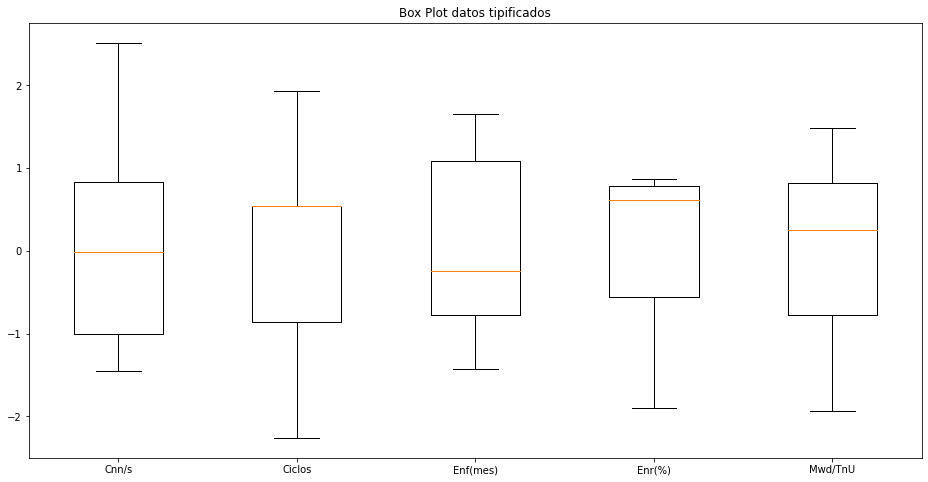

In [6]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(figsize=(16,8))
ax1.set_title('Box Plot datos tipificados')
ax1.boxplot(data.values[:,5:], labels=data.columns.tolist()[5:])
plt.show()

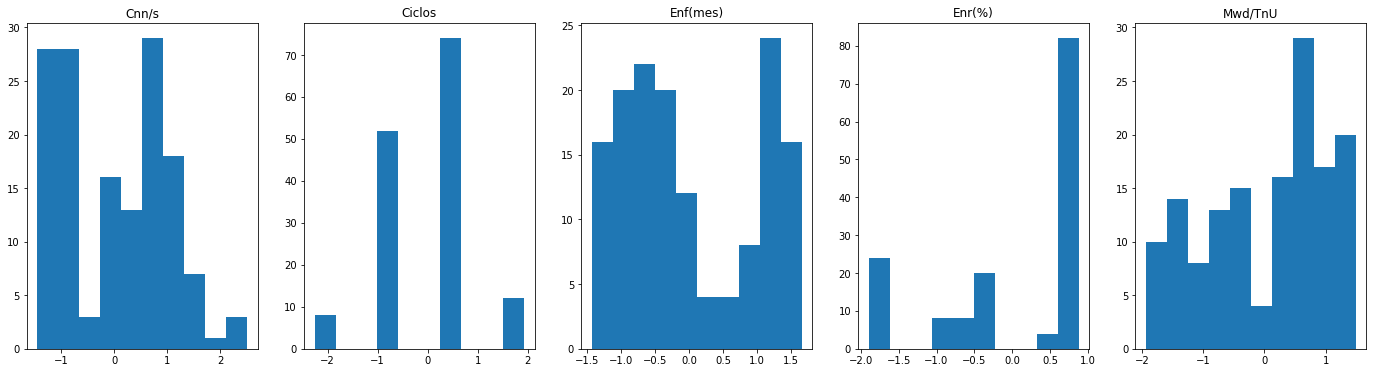

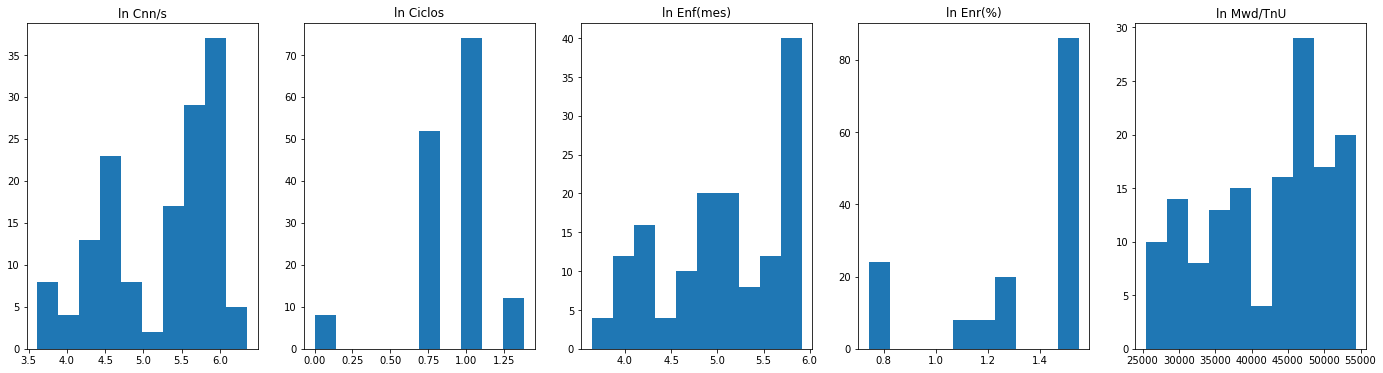

In [7]:
# Diagramas de las variables tipificadas
fig2,ax2 = plt.subplots(1,5,figsize=(24,6))
variables = data.columns.tolist()[5:]
for a,var in enumerate(variables):
    ax2[a].hist(data[var].values)
    ax2[a].set_title(var)
    a+1

# Diagramas de las variables logarítmicas
fig2L,ax2L = plt.subplots(1,5,figsize=(24,6))
variables = dataL.columns.tolist()[5:10]
for a,var in enumerate(variables):
    ax2L[a].hist(dataL[var].values)
    ax2L[a].set_title('ln ' + var)
    a+1    


plt.show()
plt.close()

In [8]:
# Discretizo para visualizar después los datos según rangos de estas variables.
# Elijo el número de intervalos según las modas en las distribuciones.
enfriDis = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans').fit_transform(data[['Enf(mes)']])
enriqDis = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans').fit_transform(data[['Enr(%)']])

# Añado las variables discretas al dataframe
data['Ciclos_D'] = df['Ciclos'].astype(float)
data['Enf(mes)_D'] = enfriDis
data['Enr(%)_D'] = enriqDis

# Lo mismo para el data frame logarítmico
enfriDisL = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans').fit_transform(dataL[['Enf(mes)']])
enriqDisL = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans').fit_transform(dataL[['Enr(%)']])

dataL['Ciclos_D'] = df['Ciclos'].astype(float)
dataL['Enf(mes)_D'] = enfriDisL
dataL['Enr(%)_D'] = enriqDisL


# data.head()
# dataL.head()

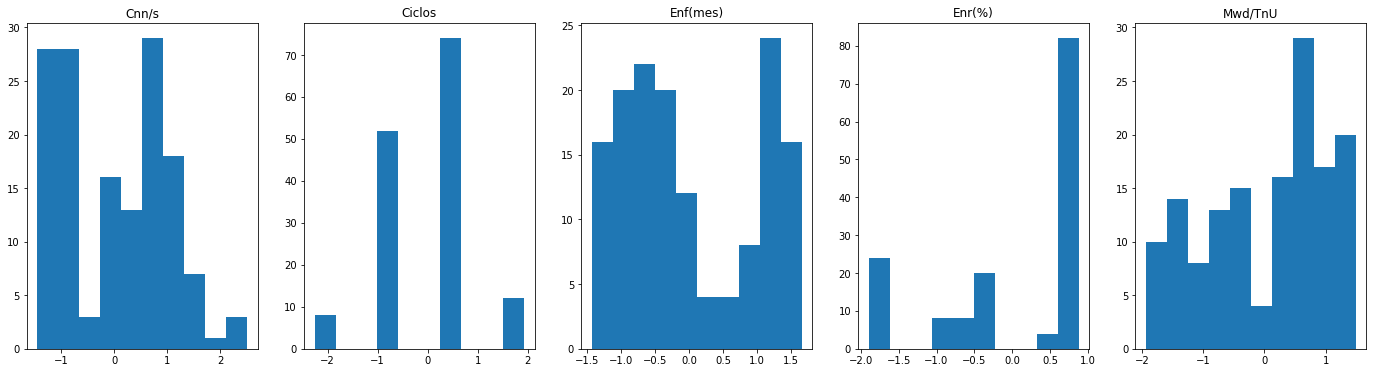

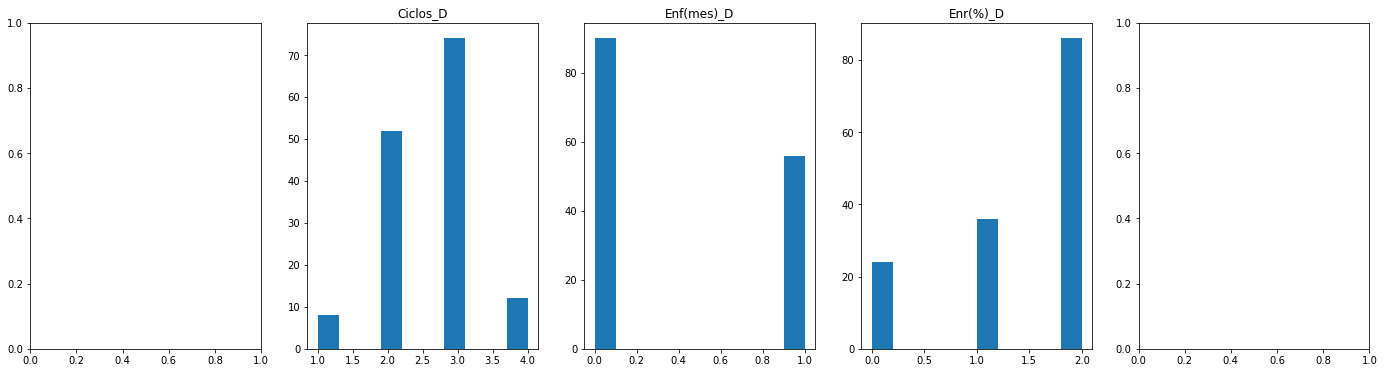

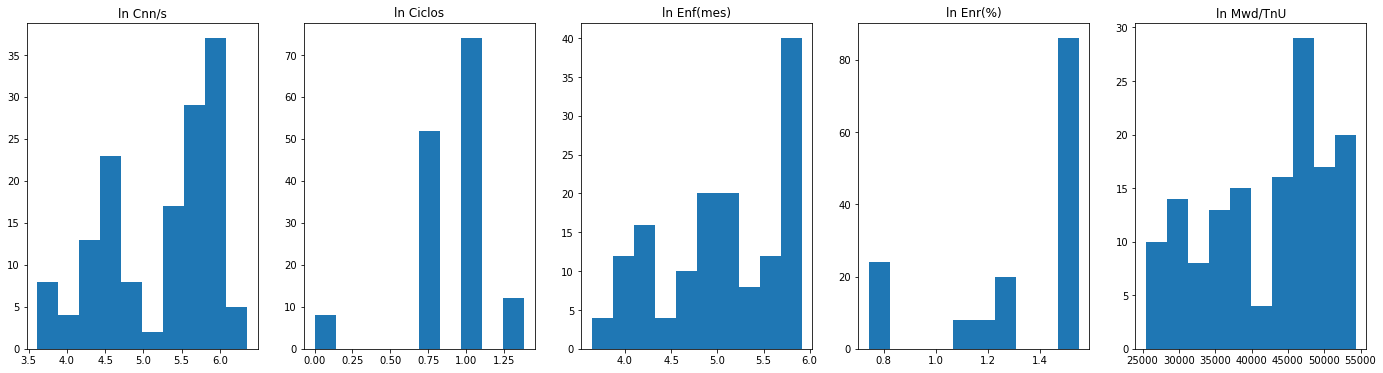

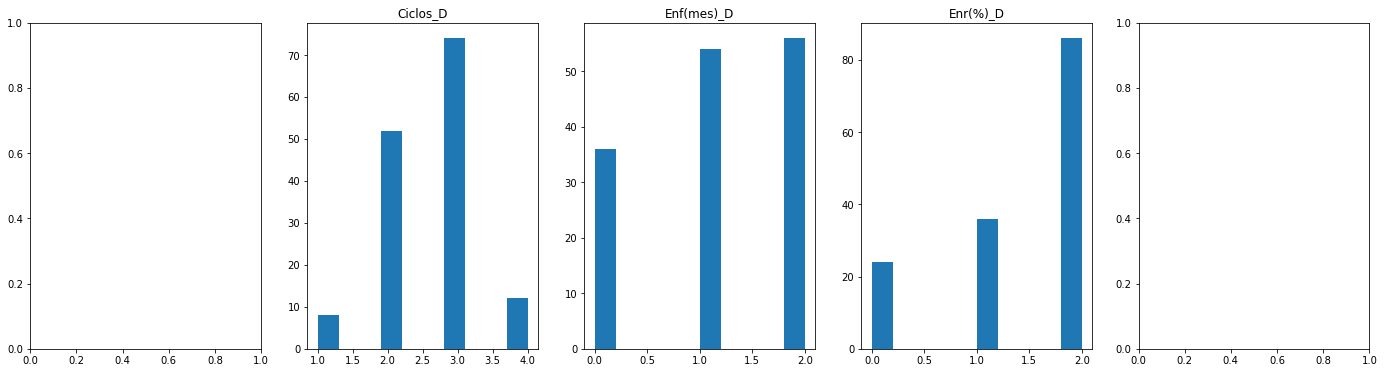

In [9]:
# Diagramas de las variables tipificadas
fig3,ax3 = plt.subplots(1,5,figsize=(24,6))
variables = data.columns.tolist()[5:10]
for a,var in enumerate(variables):
    ax3[a].hist(data[var].values)
    ax3[a].set_title(var)
    a+1

# Diagramas de las variables tipificadas & discretizadas
fig4,ax4 = plt.subplots(1,5,figsize=(24,6))
variables = data.columns.tolist()[10:]
for a,var in enumerate(variables):
    ax4[a+1].hist(data[var].values)
    ax4[a+1].set_title(var)
    a+1

# Diagramas de las variables logarítmicas
fig3L,ax3L = plt.subplots(1,5,figsize=(24,6))
variables = dataL.columns.tolist()[5:10]
for a,var in enumerate(variables):
    ax3L[a].hist(dataL[var].values)
    ax3L[a].set_title('ln ' + var)
    a+1

# Diagramas de las variables logarítmicas & discretizadas
fig4L,ax4L = plt.subplots(1,5,figsize=(24,6))
variables = dataL.columns.tolist()[10:]
for a,var in enumerate(variables):
    ax4L[a+1].hist(dataL[var].values)
    ax4L[a+1].set_title(var)
    a+1
    
    
    

plt.show()
plt.close()

### Coeficiente de correlación entre Cnn/s y Mwd/TnU

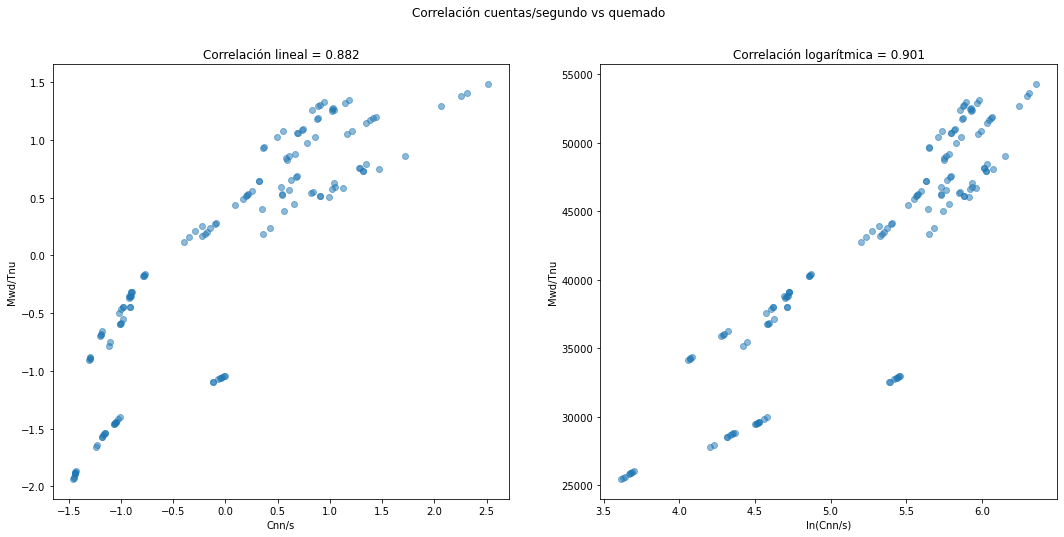

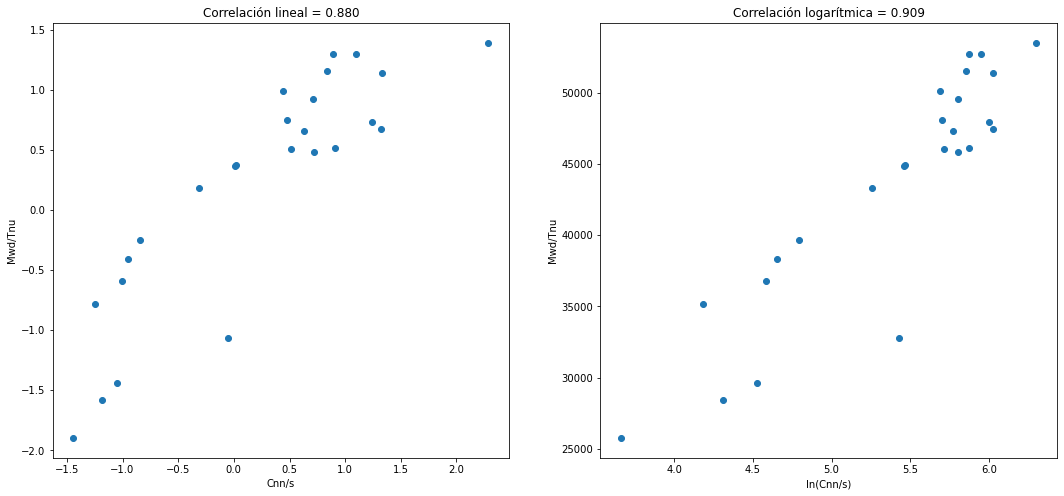

In [10]:
indep = data['Cnn/s'].values
dep = data['Mwd/TnU'].values
indepL = dataL['Cnn/s'].values
depL = dataL['Mwd/TnU'].values



corrcoef = np.corrcoef(indep, dep)
corrcoefL = np.corrcoef(indepL, depL)


fig,ax = plt.subplots(1, 2, figsize=(18,8))

ax[0].plot(indep, dep, 'o', alpha=0.5)
ax[0].set_title('Correlación lineal = {:.3f}'.format(corrcoef[0,1]))
ax[0].set_xlabel('Cnn/s')
ax[0].set_ylabel('Mwd/Tnu')

ax[1].plot(indepL, depL, 'o', alpha=0.5)
ax[1].set_title('Correlación logarítmica = {:.3f}'.format(corrcoefL[0,1]))
ax[1].set_xlabel('ln(Cnn/s)')
ax[1].set_ylabel('Mwd/Tnu')


# Para visualizar los datos por EECC en lugar de por caras:
dataEECC = data.groupby(['EECC']).mean().drop(['Muestra'], axis=1)
dataLEECC = dataL.groupby(['EECC']).mean().drop(['Muestra'], axis=1)
# dataEECC.info()
# dataLEECC.info()

indepEECC = dataEECC['Cnn/s'].values
depEECC = dataEECC['Mwd/TnU'].values
indepLEECC = dataLEECC['Cnn/s'].values
depLEECC = dataLEECC['Mwd/TnU'].values

corrcoef = np.corrcoef(indepEECC,depEECC)
corrcoefL = np.corrcoef(indepLEECC,depEECC)


figEECC,axEECC = plt.subplots(1, 2, figsize=(18,8))

axEECC[0].plot(indepEECC, depEECC, 'o')
axEECC[0].set_title('Correlación lineal = {:.3f}'.format(corrcoef[0,1]))
axEECC[0].set_xlabel('Cnn/s')
axEECC[0].set_ylabel('Mwd/Tnu')

axEECC[1].plot(indepLEECC, depLEECC, 'o')
axEECC[1].set_title('Correlación logarítmica = {:.3f}'.format(corrcoefL[0,1]))
axEECC[1].set_xlabel('ln(Cnn/s)')
axEECC[1].set_ylabel('Mwd/Tnu')

fig.suptitle('Correlación cuentas/segundo vs quemado')

plt.show()
plt.close()

### Tengo 5 data frames:

df         -->  original

data       -->  tipificado

dataEECC   -->  tipificado por EECC completos

dataL      -->  logarítmico

dataEECCL  -->  logarítmico por EECC completos

### Mínimos cuadrados:  $\beta = (X^{T}X)^{-1}X^{T}Y$

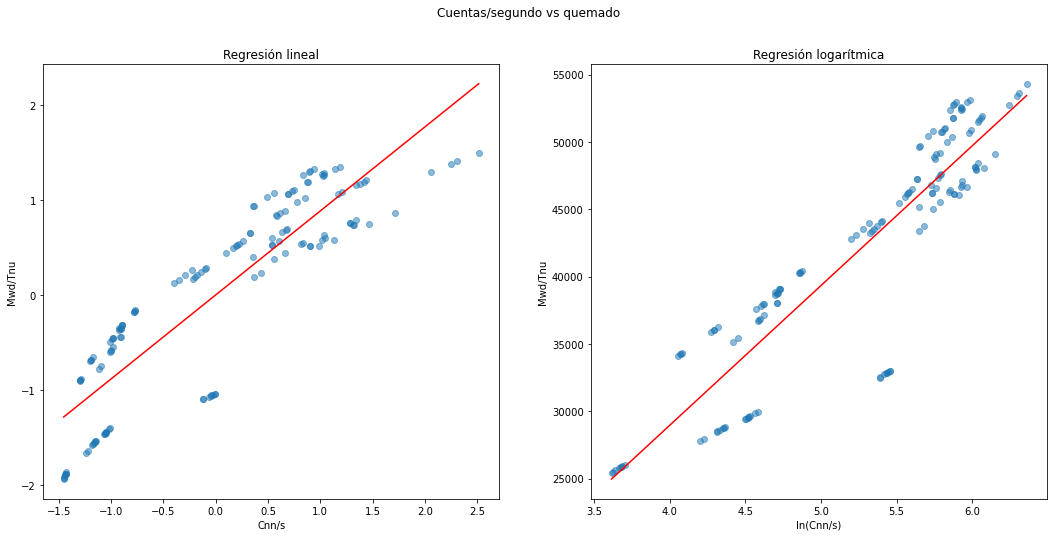

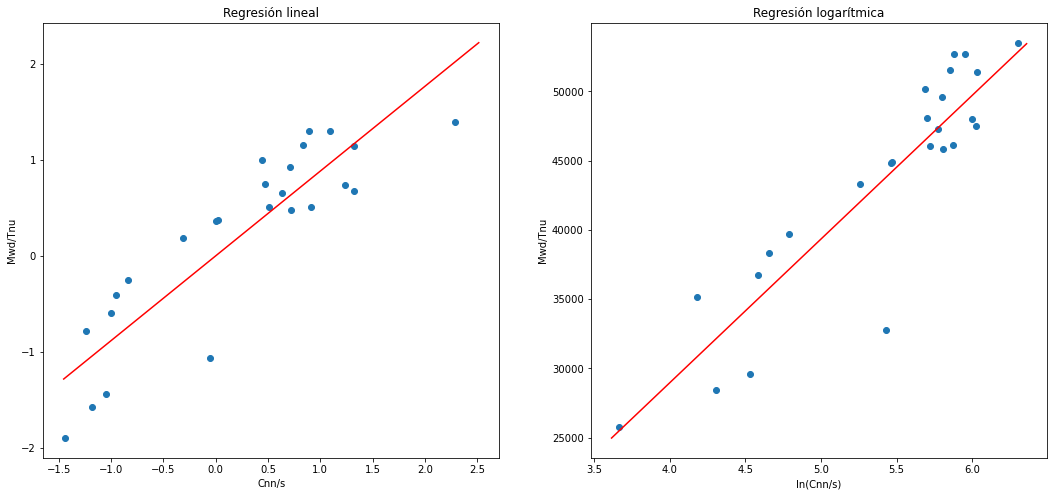

In [11]:
# Incluyo término independiente
X = np.array([np.ones(data['Cnn/s'].shape[0]), data['Cnn/s']]).T
B = np.linalg.inv(X.T @ X) @ X.T @ data['Mwd/TnU']
XL = np.array([np.ones(dataL['Cnn/s'].shape[0]), dataL['Cnn/s']]).T
BL = np.linalg.inv(XL.T @ XL) @ XL.T @ dataL['Mwd/TnU']
# print(B)
# print(BL)


# Valores extremos de abscisas
ext = (data['Cnn/s'].min(), data['Cnn/s'].max())
extL = (dataL['Cnn/s'].min(), dataL['Cnn/s'].max())
# print(ext)
# print(extL)


# Gráficas incluyendo la línea de regresión
fig,ax = plt.subplots(1, 2, figsize=(18,8))

ax[0].plot(indep, dep, 'o', alpha=0.5)
ax[0].set_title('Regresión lineal')
ax[0].set_xlabel('Cnn/s')
ax[0].set_ylabel('Mwd/Tnu')
ax[0].plot([ext[0], ext[1]], [B[0]+B[1]*ext[0], B[0]+B[1]*ext[1]], c='red')

ax[1].plot(indepL, depL, 'o', alpha=0.5)
ax[1].set_title('Regresión logarítmica')
ax[1].set_xlabel('ln(Cnn/s)')
ax[1].set_ylabel('Mwd/Tnu')
ax[1].plot([extL[0], extL[1]], [BL[0]+BL[1]*extL[0], BL[0]+BL[1]*extL[1]], c='red')

figEECC,axEECC = plt.subplots(1, 2, figsize=(18,8))

axEECC[0].plot(indepEECC, depEECC, 'o')
axEECC[0].set_title('Regresión lineal')
axEECC[0].set_xlabel('Cnn/s')
axEECC[0].set_ylabel('Mwd/Tnu')
axEECC[0].plot([ext[0], ext[1]], [B[0]+B[1]*ext[0], B[0]+B[1]*ext[1]], c='red')

axEECC[1].plot(indepLEECC, depLEECC, 'o')
axEECC[1].set_title('Regresión logarítmica')
axEECC[1].set_xlabel('ln(Cnn/s)')
axEECC[1].set_ylabel('Mwd/Tnu')
axEECC[1].plot([extL[0], extL[1]], [BL[0]+BL[1]*extL[0], BL[0]+BL[1]*extL[1]], c='red')

fig.suptitle('Cuentas/segundo vs quemado')

plt.show()
plt.close()

### Correlación separando por colores según las demás variables

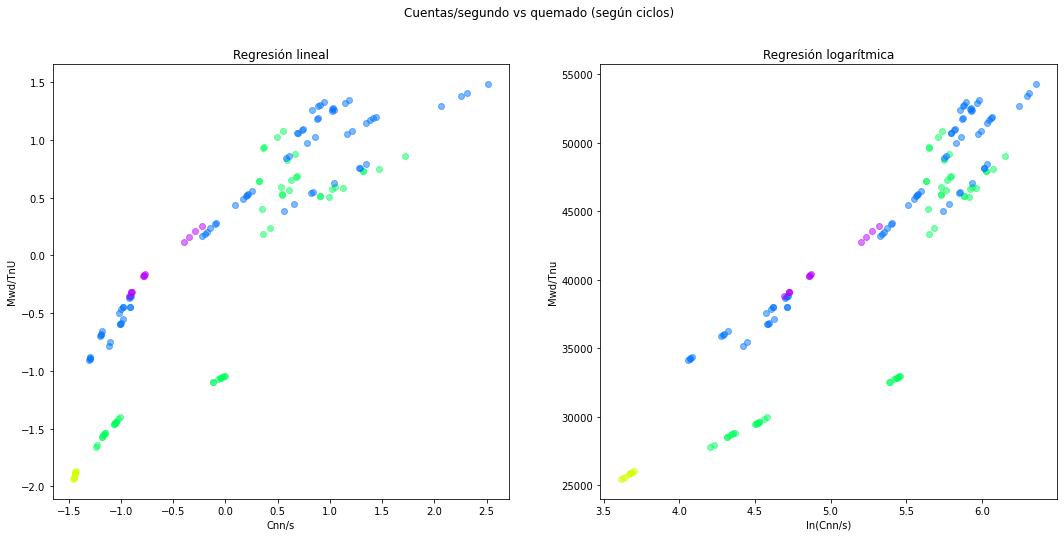

In [12]:
import matplotlib

cmap = matplotlib.cm.get_cmap('hsv')

fig,ax = plt.subplots(1, 2, figsize=(18,8))
colores = int(np.amax(data['Ciclos_D'].values)+1)
coloresL = int(np.amax(dataL['Ciclos_D'].values)+1)

for i in range(colores):
    indep = data['Cnn/s'].loc[data['Ciclos_D']==i].values
    dep = data['Mwd/TnU'].loc[data['Ciclos_D']==i].values    
    ax[0].plot(indep,dep, 'o', alpha=0.5, c=cmap(i/colores))

for i in range(coloresL): 
    indepL = dataL['Cnn/s'].loc[dataL['Ciclos_D']==i].values
    depL = dataL['Mwd/TnU'].loc[dataL['Ciclos_D']==i].values
    ax[1].plot(indepL,depL, 'o', alpha=0.5, c=cmap(i/coloresL))


ax[0].set_title('Regresión lineal')
ax[0].set_xlabel('Cnn/s')
ax[0].set_ylabel('Mwd/TnU')

ax[1].set_title('Regresión logarítmica')
ax[1].set_xlabel('ln(Cnn/s)')
ax[1].set_ylabel('Mwd/Tnu')

fig.suptitle('Cuentas/segundo vs quemado (según ciclos)')

plt.show()
plt.close()

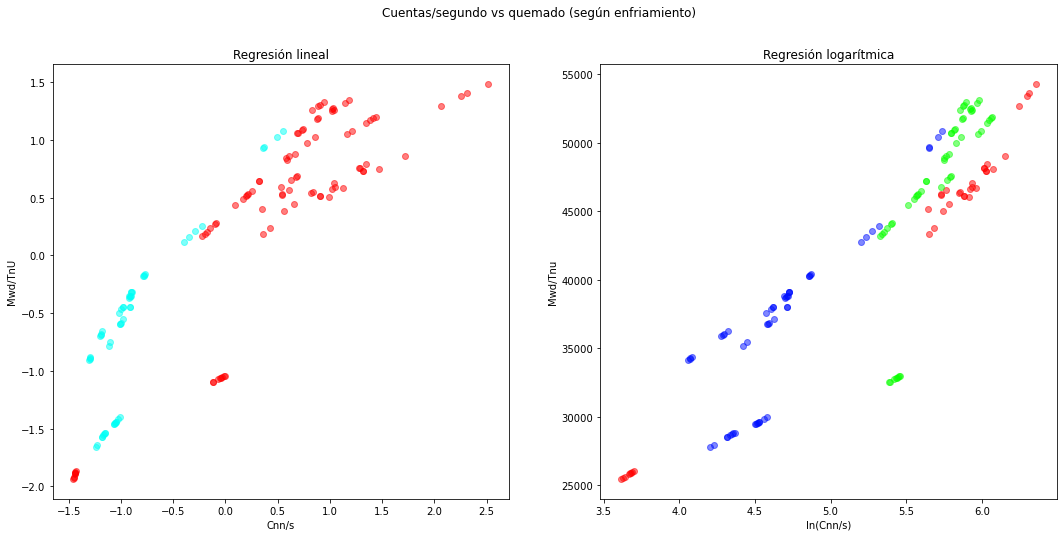

In [13]:
fig,ax = plt.subplots(1, 2, figsize=(18,8))
colores = int(np.amax(data['Enf(mes)_D'].values)+1)
coloresL = int(np.amax(dataL['Enf(mes)_D'].values)+1)

for i in range(colores):
    indep = data['Cnn/s'].loc[data['Enf(mes)_D']==i].values
    dep = data['Mwd/TnU'].loc[data['Enf(mes)_D']==i].values
    ax[0].plot(indep,dep, 'o', alpha=0.5, c=cmap(i/colores))
    
for i in range(coloresL):
    indepL = dataL['Cnn/s'].loc[dataL['Enf(mes)_D']==i].values
    depL = dataL['Mwd/TnU'].loc[dataL['Enf(mes)_D']==i].values
    ax[1].plot(indepL,depL, 'o', alpha=0.5, c=cmap(i/coloresL))


ax[0].set_title('Regresión lineal')
ax[0].set_xlabel('Cnn/s')
ax[0].set_ylabel('Mwd/TnU')

ax[1].set_title('Regresión logarítmica')
ax[1].set_xlabel('ln(Cnn/s)')
ax[1].set_ylabel('Mwd/Tnu')

fig.suptitle('Cuentas/segundo vs quemado (según enfriamiento)')

plt.show()
plt.close()

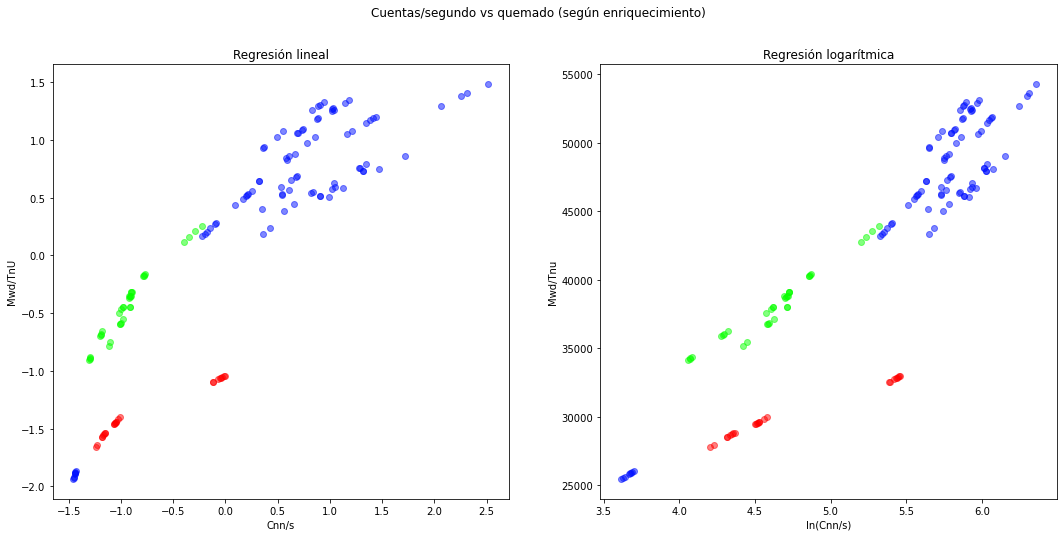

In [14]:
fig,ax = plt.subplots(1, 2, figsize=(18,8))
colores = int(np.amax(data['Enr(%)_D'].values)+1)
colores = int(np.amax(dataL['Enr(%)_D'].values)+1)

for i in range(colores):
    indep = data['Cnn/s'].loc[data['Enr(%)_D']==i].values
    dep = data['Mwd/TnU'].loc[data['Enr(%)_D']==i].values
    ax[0].plot(indep,dep, 'o', alpha=0.5, c=cmap(i/colores))

for i in range(coloresL):
    indepL = dataL['Cnn/s'].loc[dataL['Enr(%)_D']==i].values
    depL = dataL['Mwd/TnU'].loc[dataL['Enr(%)_D']==i].values
    ax[1].plot(indepL,depL, 'o', alpha=0.5, c=cmap(i/coloresL))   
    

ax[0].set_title('Regresión lineal')
ax[0].set_xlabel('Cnn/s')
ax[0].set_ylabel('Mwd/TnU')

ax[1].set_title('Regresión logarítmica')
ax[1].set_xlabel('ln(Cnn/s)')
ax[1].set_ylabel('Mwd/Tnu')

fig.suptitle('Cuentas/segundo vs quemado (según enriquecimiento)')

plt.show()
plt.close()

### Mínimos cuadrados con todas las variables: $\beta = (X^{T}X)^{-1}X^{T}Y$

In [15]:
X = np.array([np.ones(data['Cnn/s'].shape[0]), data['Cnn/s'], \
              data['Ciclos'], data['Enf(mes)'], data['Enr(%)']]).T
B = np.linalg.inv(X.T @ X) @ X.T @ data['Mwd/TnU']
XL = np.array([np.ones(dataL['Cnn/s'].shape[0]), dataL['Cnn/s'], \
               dataL['Ciclos'], dataL['Enf(mes)'], dataL['Enr(%)']]).T
BL = np.linalg.inv(XL.T @ XL) @ XL.T @ dataL['Mwd/TnU']

print(B)
print()
print(BL)

[4.345e-16 8.662e-01 1.011e-01 4.736e-01 5.258e-01]

[-48849.678   9076.753   1238.675   4287.401  15351.33 ]


Entonces:

$Mwd/Tnu \; = \; B[0] + B[1] \cdot Cnn/s + B[2] \cdot Ciclos + B[3] \cdot Enf(mes) + B[4] \cdot Enr(\%)$

$Mwd/Tnu \; = \; BL[0] + BL[1] \cdot \ln(Cnn/s) + BL[2] \cdot \ln(Ciclos) + BL[3] \cdot \ln(Enf(mes)) + BL[4] \cdot \ln(Enr(\%))$

## Método LOOCV (Leave One Out Cross Validation)

In [16]:
# df.head()

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# Creo nuevos dataframes vacíos, donde iré guardando los resultados de cada iteración.
LOOCV = pd.DataFrame(columns=['Excluido', 'Predicción', 'Validación', 'Error'])
LOOCVL = pd.DataFrame(columns=['Excluido', 'Predicción', 'Validación', 'Error'])

# Hago una lista con la identificación de cada elemento
lista = df['EECC'].unique().tolist()
# print(lista)

# En cada bucle separo las 4 u 8 medidas de un elemento en "valid" y el resto de medidas las guardo en "entren"
# para hacer las regresiones con ellas, y voy almacenando los resultados en los nuevos dataframes.
agrupa = data.groupby(data.EECC)
agrupaL = dataL.groupby(dataL.EECC)

for excluido in lista:
    # print(excluido)

    valid = agrupa.get_group(excluido)
    valid = np.mean(valid.values[:,5:10], axis=0)
    entren = data[data.EECC != excluido]
    # print(valid)
    # print(entren)
    validL = agrupaL.get_group(excluido)
    validL = np.mean(validL.values[:,5:10], axis=0)
    entrenL = dataL[dataL.EECC != excluido]
    # print(validL)
    # print(entrenL)

    X = np.array([np.ones(entren['Cnn/s'].shape[0]), entren['Cnn/s'], \
                  entren['Ciclos'], entren['Enf(mes)'], entren['Enr(%)']]).T
    B = np.linalg.inv(X.T @ X) @ X.T @ entren['Mwd/TnU']
    
    XL = np.array([np.ones(entrenL['Cnn/s'].shape[0]), entrenL['Cnn/s'], \
                   entrenL['Ciclos'], entrenL['Enf(mes)'], entrenL['Enr(%)']]).T
    BL = np.linalg.inv(XL.T @ XL) @ XL.T @ entrenL['Mwd/TnU']

    
    sol = valid[4]
    calc = B[0]+B[1]*valid[0]+B[2]*valid[1]+B[3]*valid[2]+B[4]*valid[3]
    error = ((calc - sol)/sol)*100
    # print('{0:.2f} %'.format(error))
    solL = validL[4]
    calcL = BL[0]+BL[1]*validL[0]+BL[2]*validL[1]+BL[3]*validL[2]+BL[4]*validL[3]
    errorL = ((calcL - solL)/solL)*100
    # print('{0:.2f} %'.format(errorL))
    
    
    LOOCV = LOOCV.append({'Excluido': excluido, 'Predicción': calc, 'Validación': sol, \
                          'Error': '{0:.2f}%'.format(error)}, ignore_index = True)
    
    LOOCVL = LOOCVL.append({'Excluido': excluido, 'Predicción': calcL, 'Validación': solL, \
                                'Error': '{0:.2f}%'.format(errorL)}, ignore_index = True)


print('REGRESIÓN LINEAL')
rmse = mean_squared_error(LOOCV.values[:,2], LOOCV.values[:,1], squared = False)
mae = mean_absolute_error(LOOCV.values[:,2], LOOCV.values[:,1])

display(LOOCV)
print()
print('RMSE =', '{0:.2f}'.format(rmse))
print()
print('MAE =', '{0:.2f}'.format(mae))
print()
print()
print()


print('REGRESIÓN LOGARÍTMICA')
solLT = stats.zscore(LOOCVL['Validación'])
calcLT = stats.zscore(LOOCVL['Predicción'])
rmse = mean_squared_error(LOOCVL.values[:,2], LOOCVL.values[:,1], squared = False)
mae = mean_absolute_error(LOOCVL.values[:,2], LOOCVL.values[:,1])
rmseT = mean_squared_error(solLT, calcLT, squared = False)
maeT = mean_absolute_error(solLT, calcLT)

display(LOOCVL)
print()
print('RMSE =', '{0:.2f}'.format(rmse), ' --> ', '{0:.2f}'.format(rmseT))
print()
print('MAE =', '{0:.2f}'.format(mae), ' --> ', '{0:.2f}'.format(maeT))

REGRESIÓN LINEAL


,Excluido,Predicción,Validación,Error
0,BL09,0.214449,0.371791,-42.32%
1,BT18,0.783182,0.676038,15.85%
2,BR03,0.890665,0.734825,21.21%
3,BP08,2.099059,1.391645,50.83%
4,BM09,1.317191,1.141534,15.39%
5,BK49,0.875361,0.925823,-5.45%
6,BJ12,1.327539,1.295909,2.44%
7,BH08,1.033677,1.154497,-10.47%
8,BS40,-1.181718,-1.898310,-37.75%
9,BS19,0.444042,0.511959,-13.27%



RMSE = 0.26

MAE = 0.19



REGRESIÓN LOGARÍTMICA


,Excluido,Predicción,Validación,Error
0,BL09,46870.006808,44910.000,4.36%
1,BT18,45180.633076,47477.000,-4.84%
2,BR03,47096.443201,47973.000,-1.83%
3,BP08,51610.240215,53514.750,-3.56%
4,BM09,51058.179508,51404.500,-0.67%
5,BK49,50042.539641,49584.500,0.92%
6,BJ12,51977.670726,52707.000,-1.38%
7,BH08,50735.344486,51513.875,-1.51%
8,BS40,25656.160969,25756.625,-0.39%
9,BS19,45594.816412,46092.625,-1.08%



RMSE = 1307.91  -->  0.17

MAE = 1076.20  -->  0.14


# Separando Enr(%) medio/alto del bajo en dataframe Logarítmico

In [18]:
# dataframe sin las filas con valores de Enr(%)_D igual a 0
data1 = dataL[dataL['Enr(%)_D'] != 0]
# data frame con las filas con valores de Enr(%)_D igual a 0
data2 = dataL[dataL['Enr(%)_D'] == 0]

# print(dataL.shape)
# print(dataL1.shape)
# print(dataL2.shape)

### Dibujo las regresiones con los nuevos dataframes

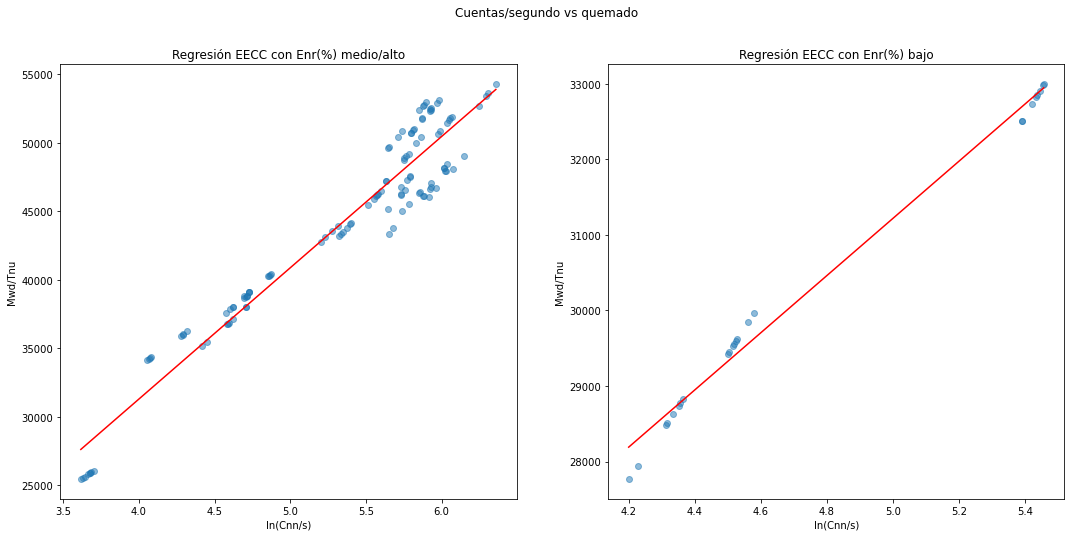

In [19]:
indep1 = data1['Cnn/s'].values
dep1 = data1['Mwd/TnU'].values
indep2 = data2['Cnn/s'].values
dep2 = data2['Mwd/TnU'].values


# Incluyo término independiente
X1 = np.array([np.ones(data1['Cnn/s'].shape[0]), data1['Cnn/s']]).T
B1 = np.linalg.inv(X1.T @ X1) @ X1.T @ data1['Mwd/TnU']
X2 = np.array([np.ones(data2['Cnn/s'].shape[0]), data2['Cnn/s']]).T
B2 = np.linalg.inv(X2.T @ X2) @ X2.T @ data2['Mwd/TnU']
# print(B)
# print(BL)


# Valores extremos de abscisas
ext1 = (data1['Cnn/s'].min(), data1['Cnn/s'].max())
ext2 = (data2['Cnn/s'].min(), data2['Cnn/s'].max())
# print(ext)
# print(extL)


# Gráficas incluyendo la línea de regresión
fig,ax = plt.subplots(1, 2, figsize=(18,8))

ax[0].plot(indep1, dep1, 'o', alpha=0.5)
ax[0].set_title('Regresión EECC con Enr(%) medio/alto')
ax[0].set_xlabel('ln(Cnn/s)')
ax[0].set_ylabel('Mwd/Tnu')
ax[0].plot([ext1[0], ext1[1]], [B1[0]+B1[1]*ext1[0], B1[0]+B1[1]*ext1[1]], c='red')

ax[1].plot(indep2, dep2, 'o', alpha=0.5)
ax[1].set_title('Regresión EECC con Enr(%) bajo')
ax[1].set_xlabel('ln(Cnn/s)')
ax[1].set_ylabel('Mwd/Tnu')
ax[1].plot([ext2[0], ext2[1]], [B2[0]+B2[1]*ext2[0], B2[0]+B2[1]*ext2[1]], c='red')

fig.suptitle('Cuentas/segundo vs quemado')

plt.show()
plt.close()

### Método LOOCV (Leave One Out Cross Validation)  

In [20]:
# nuevos dataframes vacíos, donde iré guardando los resultados de cada iteración.
LOOCV1 = pd.DataFrame(columns=['Excluido', 'Predicción', 'Validación', 'Error'])
LOOCV2 = pd.DataFrame(columns=['Excluido', 'Predicción', 'Validación', 'Error'])

# lista con la identificación de cada elemento
lista1 = data1['EECC'].unique().tolist()
lista2 = data1['EECC'].unique().tolist()

# en cada bucle separo las 4 u 8 medidas de un elemento en "valid" y el resto de medidas las guardo en "entren"
# para hacer las regresiones con ellas, y voy almacenando los resultados en los nuevos dataframes.
agrupa1 = data1.groupby(data1.EECC)
agrupa2 = data1.groupby(data1.EECC)

for excluido in lista1:
    # print(excluido)

    valid = agrupa1.get_group(excluido)
    valid = np.mean(valid.values[:,5:10], axis=0)
    entren = data1[data1.EECC != excluido]
    # print(valid)
    # print(entren)

    X = np.array([np.ones(entren['Cnn/s'].shape[0]), entren['Cnn/s'], \
                    entren['Ciclos'], entren['Enf(mes)'], entren['Enr(%)']]).T
    B = np.linalg.inv(X.T @ X) @ X.T @ entren['Mwd/TnU']

    sol = valid[4]
    calc = B[0]+B[1]*valid[0]+B[2]*valid[1]+B[3]*valid[2]+B[4]*valid[3]
    error = ((calc - sol)/sol)*100

    LOOCV1 = LOOCV1.append({'Excluido': excluido, 'Predicción': calc, 'Validación': sol, \
                            'Error': '{0:.2f}%'.format(error)}, ignore_index = True)

for excluido in lista2:
    # print(excluido)

    valid = agrupa2.get_group(excluido)
    valid = np.mean(valid.values[:,5:10], axis=0)
    entren = data2[data2.EECC != excluido]
    # print(valid)
    # print(entren)

    X = np.array([np.ones(entren['Cnn/s'].shape[0]), entren['Cnn/s'], \
                    entren['Ciclos'], entren['Enf(mes)'], entren['Enr(%)']]).T
    B = np.linalg.inv(X.T @ X) @ X.T @ entren['Mwd/TnU']

    sol = valid[4]
    calc = B[0]+B[1]*valid[0]+B[2]*valid[1]+B[3]*valid[2]+B[4]*valid[3]
    error = ((calc - sol)/sol)*100

    LOOCV2 = LOOCV2.append({'Excluido': excluido, 'Predicción': calc, 'Validación': sol, \
                            'Error': '{0:.2f}%'.format(error)}, ignore_index = True)


    
solL1T = stats.zscore(LOOCV1['Validación'])
calcL1T = stats.zscore(LOOCV1['Predicción'])
solL2T = stats.zscore(LOOCV2['Validación'])
calcL2T = stats.zscore(LOOCV2['Predicción'])


print('Regresión EECC con Enr(%) medio/alto')
rmse = mean_squared_error(LOOCV1.values[:,2], LOOCV1.values[:,1], squared = False)
rmseT = mean_squared_error(solL1T, calcL1T, squared = False)
mae = mean_absolute_error(LOOCV1.values[:,2], LOOCV1.values[:,1])
maeT = mean_absolute_error(solL1T, calcL1T)

display(LOOCV1)
print()
print('RMSE =', '{0:.2f}'.format(rmse), ' --> ', '{0:.2f}'.format(rmseT))
print()
print('MAE =', '{0:.2f}'.format(mae), ' --> ', '{0:.2f}'.format(maeT))
print()
print()
print()


print('Regresión EECC con Enr(%) bajo')
rmse = mean_squared_error(LOOCV2.values[:,2], LOOCV2.values[:,1], squared = False)
mae = mean_absolute_error(LOOCV2.values[:,2], LOOCV2.values[:,1])
rmseT = mean_squared_error(solL2T, calcL2T, squared = False)
maeT = mean_absolute_error(solL2T, calcL2T)


display(LOOCV2)
print()
print('RMSE =', '{0:.2f}'.format(rmse), ' --> ', '{0:.2f}'.format(rmseT))
print()
print('MAE =', '{0:.2f}'.format(mae), ' --> ', '{0:.2f}'.format(maeT))

Regresión EECC con Enr(%) medio/alto


,Excluido,Predicción,Validación,Error
0,BL09,46152.799059,44910.000,2.77%
1,BT18,46395.050533,47477.000,-2.28%
2,BR03,47463.913331,47973.000,-1.06%
3,BP08,51912.310262,53514.750,-2.99%
4,BM09,50854.038663,51404.500,-1.07%
5,BK49,49624.075692,49584.500,0.08%
6,BJ12,51616.846608,52707.000,-2.07%
7,BH08,50451.118396,51513.875,-2.06%
8,BS40,22444.121773,25756.625,-12.86%
9,BS19,46866.869760,46092.625,1.68%



RMSE = 1230.57  -->  0.18

MAE = 1020.65  -->  0.16



Regresión EECC con Enr(%) bajo


,Excluido,Predicción,Validación,Error
0,BL09,41081.810567,44910.000,-8.52%
1,BT18,34671.402247,47477.000,-26.97%
2,BR03,41573.824523,47973.000,-13.34%
3,BP08,44239.356989,53514.750,-17.33%
4,BM09,43955.969422,51404.500,-14.49%
5,BK49,43607.757487,49584.500,-12.05%
6,BJ12,44912.269859,52707.000,-14.79%
7,BH08,44478.721481,51513.875,-13.66%
8,BS40,12921.868413,25756.625,-49.83%
9,BS19,35109.962864,46092.625,-23.83%



RMSE = 7988.46  -->  0.81

MAE = 7180.82  -->  0.67


# Regresión con Random Forest (data set tipificado)

In [21]:
# data.head()

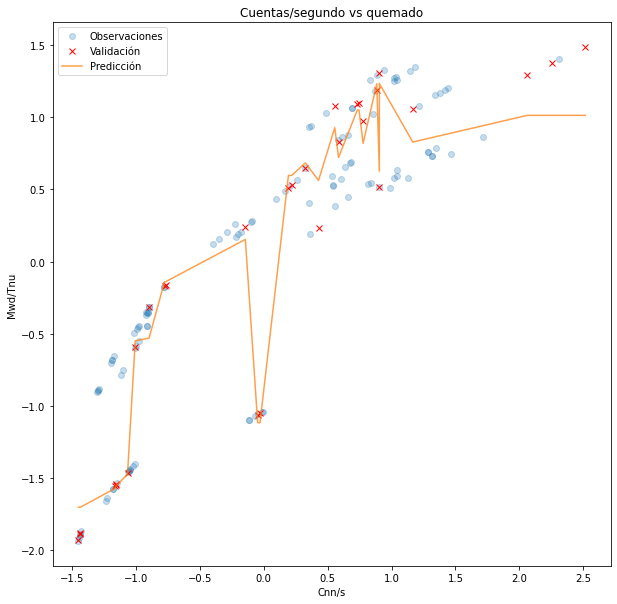

,Cnn/s_val,Mwd/TnU_val,Mwd/TnU_pred,Error
0,-1.451293,-1.925407,-1.700806,-11.67%
1,-1.437986,-1.887243,-1.700806,-9.88%
2,-1.434972,-1.878827,-1.700806,-9.48%
3,-1.167061,-1.557395,-1.572268,0.95%
4,-1.158018,-1.545069,-1.552769,0.50%
5,-1.154856,-1.540683,-1.552769,0.78%
6,-1.066705,-1.463288,-1.472671,0.64%
7,-1.006197,-0.591320,-0.548710,-7.21%
8,-0.897827,-0.315401,-0.529332,67.83%
9,-0.777032,-0.170092,-0.139238,-18.14%


Precisión del entrenamiento = 98.22%
Precisión de la validación = 97.79%

RMSE = 0.17

MAE = 0.12


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


# X almacena las variables independientes
# Y almacena la variable dependiente
X = data.iloc[:, 5:9].values
Y = data.iloc[:, 9].values
# print(X)
# print(Y)

# División de los datos en conjuntos de entrenamiento y validación
Xent, Xval, Yent, Yval = train_test_split(X, Y, test_size = 0.2)
# print(len(Xent), len(Yent))
# print(len(Xval), len(Yval))

# Aplicar el algoritmo y entrenar
bosque = RandomForestRegressor(n_estimators = 100, max_depth = 3)
bosque.fit(Xent, Yent)

# Predicción
Ypred = bosque.predict(Xval)

# Error relativo
Error = pd.DataFrame(columns=['Error'])
for n in range(len(Ypred)):
    error = ((Ypred[n] - Yval[n])/Yval[n])*100
    Error = Error.append({'Error': '{0:.2f}%'.format(error)}, ignore_index = True)


# Ordeno los valores de menor a mayor abscisa para que la representación se vea mejor
Pred = pd.DataFrame({'Cnn/s_val': Xval[:, 0], 'Mwd/TnU_val': Yval, 'Mwd/TnU_pred': Ypred, 'Error': Error['Error']})
Pred = Pred.sort_values('Cnn/s_val')
Pred = Pred.reset_index(drop=True)

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(Xent[:, 0], Yent, 'o', alpha=0.25, label='Observaciones')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_val'], 'x', color='red', label='Validación')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_pred'], alpha=0.75, label='Predicción')
ax.set_title('Cuentas/segundo vs quemado')
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/Tnu')
ax.legend(fontsize=10)
plt.show()
plt.close()


display(Pred)

precEnt = bosque.score(Xent, Yent)
precVal = bosque.score(Xval, Yval)
print('Precisión del entrenamiento =', '{0:.2f}%'.format(100*precEnt))
print('Precisión de la validación =', '{0:.2f}%'.format(100*precVal))
print()
rmse = mean_squared_error(Yval, Ypred, squared = False)
print('RMSE =', '{0:.2f}'.format(rmse))
print()
mae = mean_absolute_error(Yval, Ypred)
print('MAE =', '{0:.2f}'.format(mae))

Los resultados son tan extraordinariamente buenos porque he hecho completamente aleatoria la división de los conjuntos de entrenamiento y valicación, y hay datos de un mismo elemento en los dos conjuntos que son prácticamente idénticos.

Estoy validando prácticamente con los mimos datos con los que entreno.

### Repito la regresión separando en el conjunto de validación los datos completos de 5 elementos aleatorios

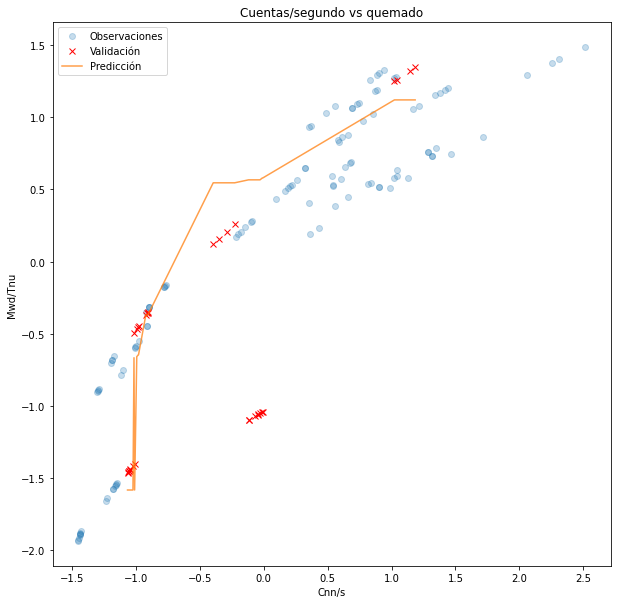

,Cnn/s_val,Mwd/TnU_val,Mwd/TnU_pred,Error
0,-1.066705,-1.463288,-1.581928,8.11%
1,-1.063911,-1.459970,-1.581928,8.35%
2,-1.056044,-1.450607,-1.581928,9.05%
3,-1.054353,-1.448592,-1.581928,9.20%
4,-1.050089,-1.443614,-1.581928,9.58%
5,-1.046854,-1.439821,-1.581928,9.87%
6,-1.024062,-1.413509,-1.581928,11.91%
7,-1.016049,-0.497569,-0.665557,33.76%
8,-1.011049,-1.398694,-1.581928,13.10%
9,-0.994286,-0.466991,-0.657978,40.90%


Precisión del entrenamiento = 98.34%
Precisión de la validación = 8.60%

RMSE = 0.84

MAE = 0.54


In [23]:
# Hago una lista con la identificación de cada elemento
lista = data['EECC'].unique().tolist()
# print(lista)

# Selecciono 5 elementos aleatorios y los separo, para generar un data frame de validación y otro de entrenamiento
random = np.random.choice(a=len(lista), size=5, replace=False)
# print(random)
valid = pd.DataFrame()
agrupa = data.groupby(data.EECC)
for excluidos in random:
    val = agrupa.get_group(lista[excluidos])
    valid = valid.append(val)
entren = data.drop(valid.index)
# print(valid)
# print(entren)


# División de los datos en conjuntos de entrenamiento y validación
Xent = entren.iloc[:, 5:9].values
Xval = valid.iloc[:, 5:9].values
Yent = entren.iloc[:, 9].values
Yval = valid.iloc[:, 9].values

# Aplicar el algoritmo y entrenar
bosque = RandomForestRegressor(n_estimators = 100, max_depth = 3)
bosque.fit(Xent, Yent)


# Predicción
Ypred = bosque.predict(Xval)

# Error relativo
Error = pd.DataFrame(columns=['Error'])
for n in range(len(Ypred)):
    error = ((Ypred[n] - Yval[n])/Yval[n])*100
    Error = Error.append({'Error': '{0:.2f}%'.format(error)}, ignore_index = True)


# Ordeno los valores de menor a mayor abscisa para que la representación se vea mejor
Pred = pd.DataFrame({'Cnn/s_val': Xval[:, 0], 'Mwd/TnU_val': Yval, 'Mwd/TnU_pred': Ypred, 'Error': Error['Error']})
Pred = Pred.sort_values('Cnn/s_val')
Pred = Pred.reset_index(drop=True)

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(Xent[:, 0], Yent, 'o', alpha=0.25, label='Observaciones')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_val'], 'x', color='red', label='Validación')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_pred'], alpha=0.75, label='Predicción')
ax.set_title('Cuentas/segundo vs quemado')
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/Tnu')
ax.legend(fontsize=10)
plt.show()
plt.close()


display(Pred)

precEnt = bosque.score(Xent, Yent)
precVal = bosque.score(Xval, Yval)
print('Precisión del entrenamiento =', '{0:.2f}%'.format(100*precEnt))
print('Precisión de la validación =', '{0:.2f}%'.format(100*precVal))
print()
rmse = mean_squared_error(Yval, Ypred, squared = False)
print('RMSE =', '{0:.2f}'.format(rmse))
print()
mae = mean_absolute_error(Yval, Ypred)
print('MAE =', '{0:.2f}'.format(mae))

#### Algunas veces hace buenas predicciones y otras tiene una precisión malísima

### Repito la regresión separando en el conjunto de validación los datos completos de 1 solo elemento aleatorio

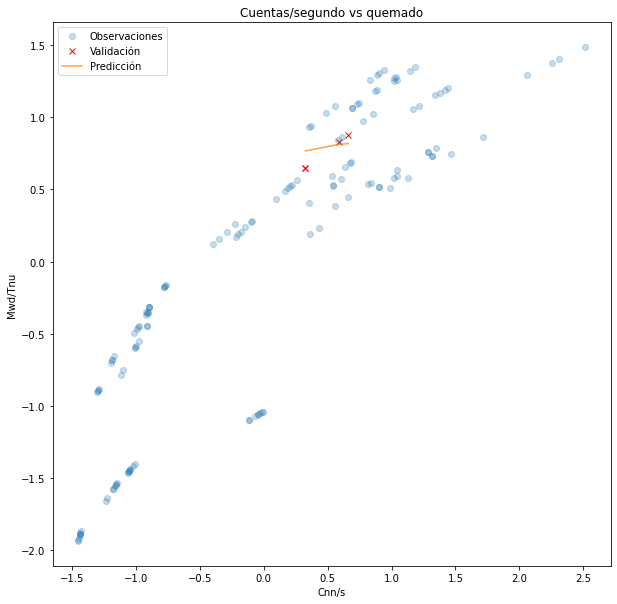

,Cnn/s_val,Mwd/TnU_val,Mwd/TnU_pred,Error
0,0.326005,0.646289,0.767335,18.73%
1,0.326226,0.646407,0.767335,18.71%
2,0.585461,0.826561,0.812076,-1.75%
3,0.662658,0.877407,0.817750,-6.80%


Precisión del entrenamiento = 98.38%
Precisión de la validación = 24.17%

RMSE = 0.09

MAE = 0.08


In [24]:
# Selecciono 1 elemento aleatorio y lo separo, para generar un data frame de validación y otro de entrenamiento.
excluido = np.random.choice(a=len(lista), size=1)
agrupa = data.groupby(data.EECC)
valid = agrupa.get_group(lista[int(excluido)])
valid = pd.DataFrame(valid)
entren = data.drop(valid.index)
# print(valid)
# print(entren)


# División de los datos en conjuntos de entrenamiento y validación
Xent = entren.iloc[:, 5:9].values
Xval = valid.iloc[:, 5:9].values
Yent = entren.iloc[:, 9].values
Yval = valid.iloc[:, 9].values

# Aplicar el algoritmo y entrenar
bosque = RandomForestRegressor(n_estimators = 100, max_depth = 3)
bosque.fit(Xent, Yent)

# Predicción
Ypred = bosque.predict(Xval)

# Error relativo
Error = pd.DataFrame(columns=['Error'])
for n in range(len(Ypred)):
    error = ((Ypred[n] - Yval[n])/Yval[n])*100
    Error = Error.append({'Error': '{0:.2f}%'.format(error)}, ignore_index = True)


# Ordeno los valores de menor a mayor abscisa para que la representación se vea mejor
Pred = pd.DataFrame({'Cnn/s_val': Xval[:, 0], 'Mwd/TnU_val': Yval, 'Mwd/TnU_pred': Ypred, 'Error': Error['Error']})
Pred = Pred.sort_values('Cnn/s_val')
Pred = Pred.reset_index(drop=True)

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(Xent[:, 0], Yent, 'o', alpha=0.25, label='Observaciones')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_val'], 'x', color='red', label='Validación')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_pred'], alpha=0.75, label='Predicción')
ax.set_title('Cuentas/segundo vs quemado')
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/Tnu')
ax.legend(fontsize=10)
plt.show()
plt.close()


display(Pred)

precEnt = bosque.score(Xent, Yent)
precVal = bosque.score(Xval, Yval)
print('Precisión del entrenamiento =', '{0:.2f}%'.format(100*precEnt))
print('Precisión de la validación =', '{0:.2f}%'.format(100*precVal))
print()
rmse = mean_squared_error(Yval, Ypred, squared = False)
print('RMSE =', '{0:.2f}'.format(rmse))
print()
mae = mean_absolute_error(Yval, Ypred)
print('MAE =', '{0:.2f}'.format(mae))

#### La precisión también es muy variable, pero en general es mucho peor.

### Repito la regresión utilizando los datos de los EECC completos just for fun.

In [25]:
# dataEECC.head()

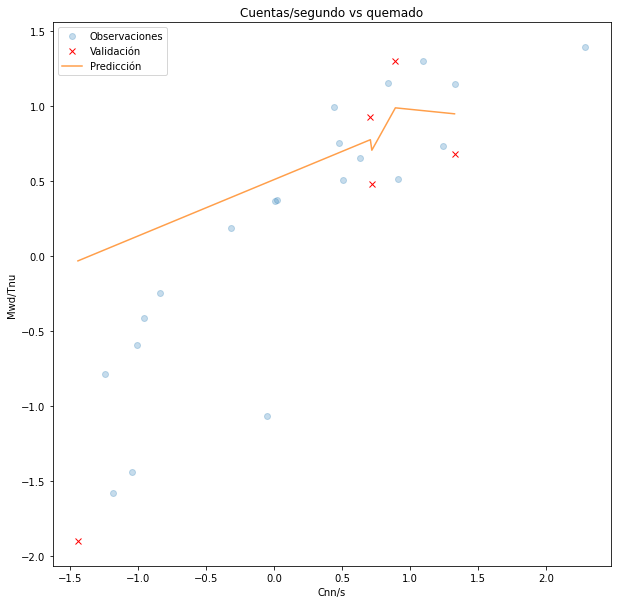

,Cnn/s_val,Mwd/TnU_val,Mwd/TnU_pred,Error
0,-1.441800,-1.898310,-0.032866,-98.27%
1,0.707267,0.925823,0.773877,-16.41%
2,0.718203,0.478313,0.703930,47.17%
3,0.891198,1.296976,0.985995,-23.98%
4,1.325873,0.676038,0.946253,39.97%


Precisión del entrenamiento = 96.05%
Precisión de la validación = 41.74%

RMSE = 0.86

MAE = 0.56


In [26]:
# X almacena las variables independientes
# Y almacena la variable dependiente
X = dataEECC.iloc[:, 3:7].values
Y = dataEECC.iloc[:, 7].values
# print(X)
# print(Y)

# División de los datos en conjuntos de entrenamiento y validación
Xent, Xval, Yent, Yval = train_test_split(X, Y, test_size = 0.2)
# print(len(Xent), len(Yent))
# print(len(Xval), len(Yval))

# Aplicar el algoritmo y entrenar
bosque = RandomForestRegressor(n_estimators = 100, max_depth = 3)
bosque.fit(Xent, Yent)

# Predicción
Ypred = bosque.predict(Xval)

# Error relativo
Error = pd.DataFrame(columns=['Error'])
for n in range(len(Ypred)):
    error = ((Ypred[n] - Yval[n])/Yval[n])*100
    Error = Error.append({'Error': '{0:.2f}%'.format(error)}, ignore_index = True)


# Ordeno los valores de menor a mayor abscisa para que la representación se vea mejor
Pred = pd.DataFrame({'Cnn/s_val': Xval[:, 0], 'Mwd/TnU_val': Yval, 'Mwd/TnU_pred': Ypred, 'Error': Error['Error']})
Pred = Pred.sort_values('Cnn/s_val')
Pred = Pred.reset_index(drop=True)

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(Xent[:, 0], Yent, 'o', alpha=0.25, label='Observaciones')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_val'], 'x', color='red', label='Validación')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_pred'], alpha=0.75, label='Predicción')
ax.set_title('Cuentas/segundo vs quemado')
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/Tnu')
ax.legend(fontsize=10)
plt.show()
plt.close()


display(Pred)

precEnt = bosque.score(Xent, Yent)
precVal = bosque.score(Xval, Yval)
print('Precisión del entrenamiento =', '{0:.2f}%'.format(100*precEnt))
print('Precisión de la validación =', '{0:.2f}%'.format(100*precVal))
print()
rmse = mean_squared_error(Yval, Ypred, squared = False)
print('RMSE =', '{0:.2f}'.format(rmse))
print()
mae = mean_absolute_error(Yval, Ypred)
print('MAE =', '{0:.2f}'.format(mae))

Parece que la muestra es demasiado pequeña para que puedan hacerse buenas predicciones, al menos con este método.

# Regresión con Random Forest (data set logarítmico)

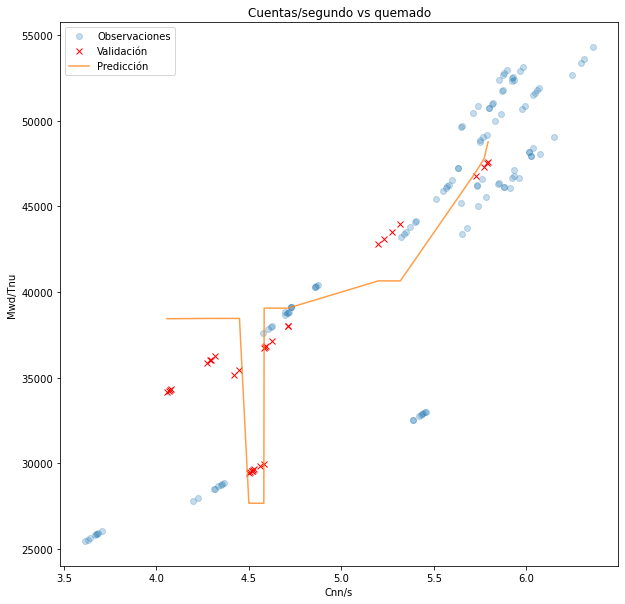

,Cnn/s_val,Mwd/TnU_val,Mwd/TnU_pred,Error
0,4.056470,34131,38438.890576,12.62%
1,4.069198,34231,38438.890576,12.29%
2,4.072099,34253,38438.890576,12.22%
3,4.081259,34324,38438.890576,11.99%
4,4.275415,35873,38454.387076,7.20%
5,4.290733,35998,38454.387076,6.82%
6,4.293332,36019,38454.387076,6.76%
7,4.319087,36230,38454.387076,6.14%
8,4.418479,35166,38455.627076,9.35%
9,4.448750,35451,38455.627076,8.48%


Precisión del entrenamiento = 98.65%
Precisión de la validación = 81.21%

RMSE = 0.39

MAE = 0.34


In [27]:
# Hago una lista con la identificación de cada elemento
lista = dataL['EECC'].unique().tolist()
# print(lista)

# Selecciono 5 elementos aleatorios y los separo, para generar un data frame de validación y otro de entrenamiento
random = np.random.choice(a=len(lista), size=5, replace=False)
# print(random)
valid = pd.DataFrame()
agrupa = dataL.groupby(dataL.EECC)
for excluidos in random:
    val = agrupa.get_group(lista[excluidos])
    valid = valid.append(val)
entren = dataL.drop(valid.index)
# print(valid)
# print(entren)


# División de los datos en conjuntos de entrenamiento y validación
Xent = entren.iloc[:, 5:9].values
Xval = valid.iloc[:, 5:9].values
Yent = entren.iloc[:, 9].values
Yval = valid.iloc[:, 9].values

# Aplicar el algoritmo y entrenar
bosque = RandomForestRegressor(n_estimators = 100, max_depth = 3)
bosque.fit(Xent, Yent)


# Predicción
Ypred = bosque.predict(Xval)

# Error relativo
Error = pd.DataFrame(columns=['Error'])
for n in range(len(Ypred)):
    error = ((Ypred[n] - Yval[n])/Yval[n])*100
    Error = Error.append({'Error': '{0:.2f}%'.format(error)}, ignore_index = True)


# Ordeno los valores de menor a mayor abscisa para que la representación se vea mejor
Pred = pd.DataFrame({'Cnn/s_val': Xval[:, 0], 'Mwd/TnU_val': Yval, 'Mwd/TnU_pred': Ypred, 'Error': Error['Error']})
Pred = Pred.sort_values('Cnn/s_val')
Pred = Pred.reset_index(drop=True)

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(Xent[:, 0], Yent, 'o', alpha=0.25, label='Observaciones')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_val'], 'x', color='red', label='Validación')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_pred'], alpha=0.75, label='Predicción')
ax.set_title('Cuentas/segundo vs quemado')
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/Tnu')
ax.legend(fontsize=10)
plt.show()
plt.close()


display(Pred)

precEnt = bosque.score(Xent, Yent)
precVal = bosque.score(Xval, Yval)
print('Precisión del entrenamiento =', '{0:.2f}%'.format(100*precEnt))
print('Precisión de la validación =', '{0:.2f}%'.format(100*precVal))
print()
# Calculo los errores cuadrático y absoluto medios con los resultados tipificados
YvalT = stats.zscore(Yval)
YpredT = stats.zscore(Ypred)
rmse = mean_squared_error(YvalT, YpredT, squared = False)
print('RMSE =', '{0:.2f}'.format(rmse))
print()
mae = mean_absolute_error(YvalT, YpredT)
print('MAE =', '{0:.2f}'.format(mae))

## Itero la regresión varias veces con diferentes valores de profundidad y árboles

In [28]:
# Creo nuevo dataframe vacío, donde guardar los resultados de cada iteración.
resultados = pd.DataFrame(columns = ['PROFUNDIDAD', 'ARBOLES', 'PRECISION_ENT', 'PRECISION_VAL', 'RMSE', 'MAE'])

# El número mínimo de árboles (en centenas)
ranMin = 5
# La cantidad de veces que aumentamos los árboles (de 100 en 100)
itera = 10
# La cantidad de veces que repetimos la regresión con los mismos árboles y profundidad
media = 20

for prof in range(3, 6):
    for arb in range(ranMin*100, ranMin*100*itera+1, 100):
        n = 0
        precEntM = 0
        precValM = 0
        rmseM = 0
        maeM = 0
        
        # Repito la regresión para obtener la media de todas
        while n < media:
            # Selecciono 5 elementos aleatorios y los separo, para generar un data frame de
            # validación y otro de entrenamiento
            random = np.random.choice(a=len(lista), size=5, replace=False)
            valid = pd.DataFrame()
            agrupa = dataL.groupby(dataL.EECC)
            for excluidos in random:
                val = agrupa.get_group(lista[excluidos])
                valid = valid.append(val)
            entren = dataL.drop(valid.index)

            # División de los datos en conjuntos de entrenamiento y validación
            Xent = entren.iloc[:, 5:9].values
            Xval = valid.iloc[:, 5:9].values
            Yent = entren.iloc[:, 9].values
            Yval = valid.iloc[:, 9].values

            # Aplicar el algoritmo y entrenar
            bosque = RandomForestRegressor(n_estimators = prof, max_depth = arb)
            bosque.fit(Xent, Yent)

            # Predicción
            Ypred = bosque.predict(Xval)

            # Calculo las precisiones
            precEnt = bosque.score(Xent, Yent)
            precVal = bosque.score(Xval, Yval)            
            # Calculo los errores cuadrático y absoluto medios con los resultados tipificados
            YvalT = stats.zscore(Yval)
            YpredT = stats.zscore(Ypred)
            rmse = mean_squared_error(YvalT, YpredT, squared = False)
            mae = mean_absolute_error(YvalT, YpredT)

            # Sumo los resultados de cada iteración para obtener después la media
            precEntM = precEntM + precEnt
            precValM = precValM + precVal
            rmseM = rmseM + rmse
            maeM = maeM + mae

            n += 1
        
        # Calculo la media de las precisiones
        precEntM = precEntM/media
        precValM = precValM/media
        rmseM = rmseM/media
        maeM = maeM/media

        # Guardo los resultados en un data frame
        resultados = resultados.append({'PROFUNDIDAD': prof, 'ARBOLES': arb, \
                                        'PRECISION_ENT': precEntM, 'PRECISION_VAL': precValM, \
                                        'RMSE': rmseM, 'MAE': maeM}, ignore_index=True)

print(resultados)

     PROFUNDIDAD  ARBOLES  PRECISION_ENT  PRECISION_VAL      RMSE       MAE
0            3.0    500.0       0.998565       0.226621  0.678787  0.581389
1            3.0    600.0       0.998190       0.474070  0.521577  0.426700
2            3.0    700.0       0.998613       0.566128  0.531269  0.443878
3            3.0    800.0       0.998457       0.252747  0.583486  0.480099
4            3.0    900.0       0.997998       0.492407  0.485759  0.409268
..           ...      ...            ...            ...       ...       ...
133          5.0   4600.0       0.999128       0.604923  0.462662  0.383711
134          5.0   4700.0       0.999076       0.571506  0.436347  0.358479
135          5.0   4800.0       0.998938       0.347699  0.651940  0.535629
136          5.0   4900.0       0.999333       0.441245  0.505834  0.397371
137          5.0   5000.0       0.998736       0.621670  0.450331  0.373790

[138 rows x 6 columns]


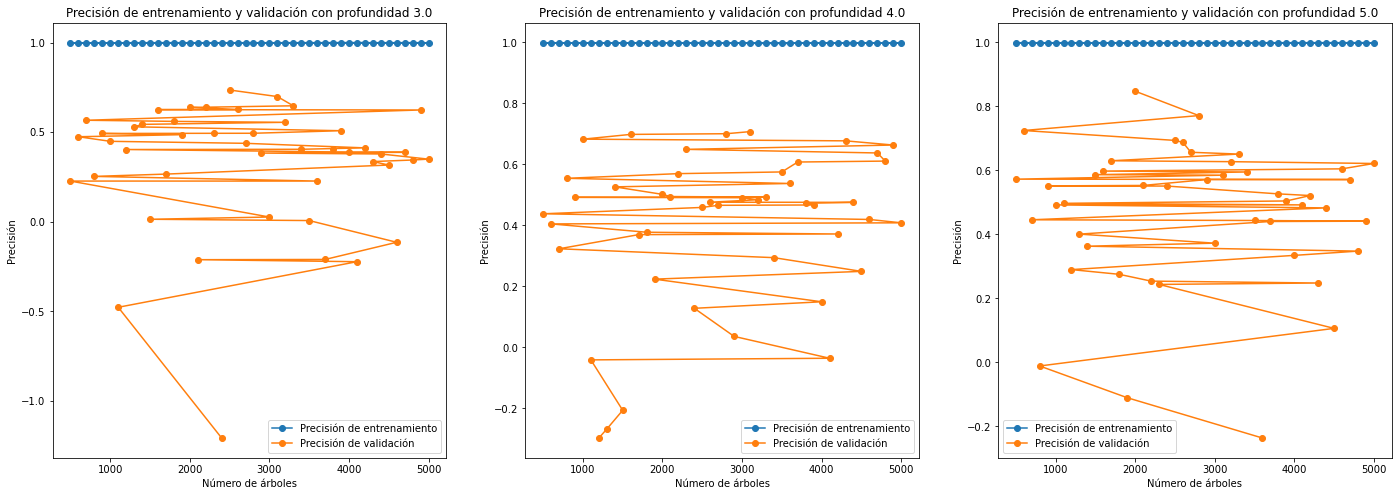

In [29]:
#represento la precisión de entrenamiento y validación respecto al número de árboles para cada profundidad
fig,ax = plt.subplots(1,3,figsize=(24,8))
profundidades = resultados['PROFUNDIDAD'].unique().tolist()
agrupa = resultados.groupby(resultados.PROFUNDIDAD)


# un bucle con un data frame para cada profundidad
for a,prof in enumerate(profundidades):
    # selecciono los datos de la profundidad
    datos = agrupa.get_group(prof)
    # reordeno los datos de mejor a peor precisión de validación
    datos = datos.sort_values(by = 'PRECISION_VAL', ascending = False).reset_index(drop=True)
    # represento la precisión de entrenamiento y validación respecto a la profundidad y número de árboles
    ax[a].plot(datos['ARBOLES'], datos['PRECISION_ENT'], '-o', label = 'Precisión de entrenamiento')
    ax[a].plot(datos['ARBOLES'], datos['PRECISION_VAL'], '-o', label = 'Precisión de validación')
    ax[a].set_xlabel('Número de árboles')
    ax[a].set_ylabel('Precisión')
    ax[a].set_title('Precisión de entrenamiento y validación con profundidad ' + str(prof))
    ax[a].legend()
    a+1

plt.show()
plt.close()